<a href="https://colab.research.google.com/github/AlahmadiAmal/malicious-powershell-attention/blob/main/bert-features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following notebook studies the validity of BERT extracted tokens and compares it with a normal tensorflow Tokenizer.   

# Installations

In [2]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Import Libraries

In [14]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import numpy as np
from google.colab import drive
from xgboost import XGBClassifier
from sklearn.metrics import classification_report , roc_auc_score, f1_score, precision_score, recall_score, accuracy_score , confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Input, GaussianNoise


# Mount Drive

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Building the dataframe

The tokens were extracted using the PSParse tokenizer in powershell, the resulting tokens were saved in text files. The build.py entails how the content of these text files were converted into a numpy array.  

In [ ]:
benign_tokens = np.load('/content/drive/MyDrive/Work #2 PowerShell/Dataset/np_benign_tokens.npy', allow_pickle=True)
benign_scripts = np.load('/content/drive/MyDrive/Work #2 PowerShell/Dataset/np_benign_script.npy', allow_pickle=True)
malicious_scripts = np.load('/content/drive/MyDrive/Work #2 PowerShell/Dataset/np_malicious_script.npy', allow_pickle=True)
malicious_tokens = np.load('/content/drive/MyDrive/Work #2 PowerShell/Dataset/np_malicious_tokens.npy', allow_pickle=True)

In [ ]:
mal_tokens = []
for script in malicious_tokens:
  tmp = []
  for token in script:
    tmp.append(token[0])
  mal_tokens.append(tmp)

In [ ]:
np_mal_tokens = np.array(mal_tokens)

In [ ]:
ben_tokens = []
for script in benign_tokens:
  tmp = []
  for token in script:
    tmp.append(token[0])
  ben_tokens.append(tmp)

In [ ]:
np_ben_tokens = np.array(ben_tokens)

In [ ]:
mal_dict = {}
for s in range(len(np_mal_tokens)):
  try:
    data = {'Script' : malicious_scripts[s],
                'Tokens' : np_mal_tokens[s],
                'Label' : 0}
    mal_dict[s] = data
  except: 
    continue

mal_df = pd.DataFrame(mal_dict)
mal_df = mal_df.transpose()

In [ ]:
ben_dict = {}
for s in range(len(np_ben_tokens)):
  try:
    data = {'Script' : benign_scripts[s],
                'Tokens' : np_ben_tokens[s],
                'Label' : 1}
    ben_dict[s] = data
  except: 
    continue

ben_df = pd.DataFrame(ben_dict)
ben_df = ben_df.transpose()

In [ ]:
dataset = pd.concat([ben_df, mal_df])
dataset = dataset.reset_index(drop = True)

Based on the work done by Choi et al. [1] only six tokens are of real value, we filtered the token list based on their implementation.

In [ ]:
filtered_tokens = []
wanted_tokens = ['Command', 'CommandArgument', 'CommandParameter', 'Keyword', 'Member','Variable']
for row in range(len(dataset)):
  tokens = dataset.Tokens[row]
  tokens = tokens[1:-2]
  tokens = re.sub(r'[^\w\s,]', '', tokens)
  tokens = tokens.split(',')
  tmp = []
  for token in tokens:
    if token.strip() in wanted_tokens:
      tmp.append(token.strip())
  filtered_tokens.append(tmp)

In [ ]:
np_filtered_tokens = np.array(filtered_tokens)

In [ ]:
dataset['Filtered Tokens'] = np_filtered_tokens

In [6]:
dataset.head()

,Script,Tokens,Label,Filtered Tokens
0,function Get-QlikServiceCluster {[CmdletBindin...,"['Keyword', 'CommandArgument', 'GroupStart', '...",1,"['Keyword', 'CommandArgument', 'Keyword', 'Mem..."
1,cmdlet,"['Keyword', 'CommandArgument', 'GroupStart', '...",1,"['Keyword', 'CommandArgument', 'Variable', 'Co..."
2,function Connect-ExchangeOnline {param([system...,"['Keyword', 'CommandArgument', 'GroupStart', '...",1,"['Keyword', 'CommandArgument', 'Variable', 'Va..."
3,"$xlr8r = [psobject].assembly.gettype(""System.M...","['Variable', 'Operator', 'String', 'Variable',...",1,"['Variable', 'Variable', 'Keyword', 'Variable'..."
4,function Get-Input{param([Parameter(Mandatory=...,"['Keyword', 'CommandArgument', 'GroupStart', '...",1,"['Keyword', 'CommandArgument', 'Keyword', 'Var..."


In [11]:
y = dataset.Label
X = np_filtered_tokens

# Split into Training and Testing Sets

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(X,y,test_size=0.2, shuffle = True)

# BERT Embedding

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
bert = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 1262970.85B/s]


In [ ]:
x_train[0]

['Keyword',
 'CommandArgument',
 'Keyword',
 'Keyword',
 'Variable',
 'Variable',
 'Variable',
 'Member',
 'Variable',
 'Member',
 'Keyword',
 'Command',
 'CommandArgument']

In [ ]:
train_sentences = []
for i in range(len(x_train)):
  sentence = "[CLS] "
  for j in range(len(x_train[i])):
      sentence = sentence + ' '+str(x_train[i][j])
  sentence = sentence + " [SEP]"
  train_sentences.append(sentence.strip())

train_sentences[0]

'[CLS]  Keyword CommandArgument Keyword Keyword Variable Variable Variable Member Variable Member Keyword Command CommandArgument [SEP]'

In [ ]:
len(train_sentences)

19761

In [ ]:
bert_train = []
for i in range(len(train_sentences)):
  if len(train_sentences[i])>512: #bert takes a vector of length 512 at max, if sentence is longer slice 
    tokenized_bert = bert.tokenize(train_sentences[i][:512])
  else:
    tokenized_bert = bert.tokenize(train_sentences[i])
  indexed_tokens = bert.convert_tokens_to_ids(tokenized_bert)
  bert_train.append(indexed_tokens)

bert_train[0]

[101,
 3145,
 18351,
 3094,
 2906,
 22850,
 4765,
 3145,
 18351,
 3145,
 18351,
 8023,
 8023,
 8023,
 2266,
 8023,
 2266,
 3145,
 18351,
 3094,
 3094,
 2906,
 22850,
 4765,
 102]

In [ ]:
bert_padded_train = bert_train.copy()
for i in range(len(bert_padded_train)):
  while len(bert_padded_train[i]) < 512:
    bert_padded_train[i].append(0)

In [ ]:
bert_padded_train_np = np.array(bert_padded_train)
bert_padded_train_np.shape

(19761, 512)

In [ ]:
bert_padded_train_normal = preprocessing.normalize(bert_padded_train_np) #normalize features 
bert_padded_train_normal[0]

array([0.00191227, 0.05954529, 0.34744537, 0.05857969, 0.05502023,
       0.43262638, 0.09021727, 0.05954529, 0.34744537, 0.05954529,
       0.34744537, 0.15190203, 0.15190203, 0.15190203, 0.0429029 ,
       0.15190203, 0.0429029 , 0.05954529, 0.34744537, 0.05857969,
       0.05857969, 0.05502023, 0.43262638, 0.09021727, 0.0019312 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
test_sentences = []
for i in range(len(x_test)):
  sentence = "[CLS] "
  for j in range(len(x_test[i])):
      sentence = sentence + ' '+str(x_test[i][j])
  sentence = sentence + " [SEP]"
  test_sentences.append(sentence.strip())

test_sentences[0]

'[CLS]  Keyword CommandArgument Keyword Command Variable Member Member [SEP]'

In [ ]:
len(test_sentences)

4941

In [ ]:
bert_test = []
for i in range(len(test_sentences)):
  if len(test_sentences[i])>512:
    tokenized_bert = bert.tokenize(test_sentences[i][:512])
  else:
    tokenized_bert = bert.tokenize(test_sentences[i])
  indexed_tokens = bert.convert_tokens_to_ids(tokenized_bert)
  bert_test.append(indexed_tokens)

bert_test[0]

[101,
 3145,
 18351,
 3094,
 2906,
 22850,
 4765,
 3145,
 18351,
 3094,
 8023,
 2266,
 2266,
 102]

In [ ]:
bert_padded_test = bert_test.copy()
for i in range(len(bert_padded_test)):
  while len(bert_padded_test[i]) < 512:
    bert_padded_test[i].append(0)

len(bert_padded_test[0])

512

In [ ]:
bert_padded_test_np = np.array(bert_padded_test)
bert_padded_test_np.shape

(4941, 512)

In [ ]:
bert_padded_test_normal = preprocessing.normalize(bert_padded_test_np)

# Tensorflow Tokenization

In [ ]:
num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [ ]:
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(x_train)

In [ ]:
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=1024)

In [ ]:
train_padded_norm = preprocessing.normalize(train_padded)

In [ ]:
tokenizer_test = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer_test.fit_on_texts(x_test)

In [ ]:
test_sequences = tokenizer_test.texts_to_sequences(x_test)

In [ ]:
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type)

In [ ]:
test_padded_np = np.array(test_padded)

# Classification with BERT Tokens

              precision    recall  f1-score   support

           0       0.95      0.71      0.81      3011
           1       0.68      0.94      0.79      1930

    accuracy                           0.80      4941
   macro avg       0.81      0.82      0.80      4941
weighted avg       0.84      0.80      0.80      4941


Accuracy: 0.800850
AUC: 0.824973
F1: 0.785808
Precision: 0.677553
Recall: 0.935233
TPR: 93.523316
FPR: 28.528728
FNR: 6.476684
TNR: 71.471272



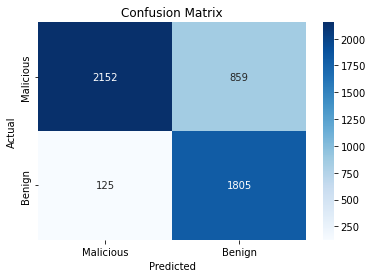

In [ ]:
clf = XGBClassifier()
clf.fit(bert_padded_train_normal, y_train)
predictions = clf.predict(bert_padded_test_normal)

score = accuracy_score(y_test, predictions)

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
tpr = (tp/(tp+fn))*100
fpr = (fp/(fp+tn))*100
fnr = (fn/(fn+tp))*100
tnr = (tn/(tn+fp))*100
matrix = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
test_result = "\nAccuracy: %f\nAUC: %f\nF1: %f\nPrecision: %f\nRecall: %f\nTPR: %f\nFPR: %f\nFNR: %f\nTNR: %f\n" %(score,auc,f1, precision, recall, tpr,fpr,fnr,tnr)
print(report)
print(test_result)
cm = sns.heatmap(matrix, annot=True, fmt="d",cmap='Blues', xticklabels=['Malicious', 'Benign'],yticklabels=['Malicious', 'Benign'])
cm.set(xlabel='Predicted', ylabel='Actual',title="Confusion Matrix")
plt.show()

# SdA Architecture

In [ ]:
def buildSdA (layers, units): #function to define SdA structure
    autoencoder=Sequential()
    autoencoder.add(Input (shape=units))
    autoencoder.add(GaussianNoise(0.5))
    nodes = list()
    nodes.append(units)
    #encoder
    for i in range(layers):
        if i==layers-1: #bottleneck layer = last iteration
            autoencoder.add(Dense (nodes[i], activation='linear'))
        else:
            autoencoder.add(Dense (nodes[i], activation='sigmoid'))
            unit= nodes[i]/2 #half unit for next layer
            nodes.append(unit)
    #decoder
    for i in range(1,len(nodes)+1):
        autoencoder.add(Dense (nodes[-i], activation='sigmoid')) #iterate over same units in opposite manner
         
    autoencoder.add(Dense(1))
    autoencoder.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    return autoencoder 

In [ ]:
tokenizer_test = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer_test.fit_on_texts(x_test)
test_sequences = tokenizer_test.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=1024)
test_padded_norm = preprocessing.normalize(test_padded)

# Classification with SdA and BERT Tokens

155/155 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.71      0.82      3011
           1       0.68      0.94      0.79      1930

    accuracy                           0.80      4941
   macro avg       0.82      0.83      0.80      4941
weighted avg       0.85      0.80      0.81      4941


Accuracy: 0.803683
AUC: 0.828786
F1: 0.789679
Precision: 0.678971
Recall: 0.943523
TPR: 94.352332
FPR: 28.595151
FNR: 5.647668
TNR: 71.404849



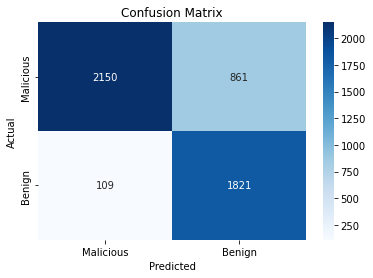

In [ ]:
model = buildSdA(1,512)
model.fit(bert_padded_train_normal,y_train,epochs=25, verbose=0)

bottleneck = Model (inputs=model.inputs, outputs=model.layers[0].output) #define only encoder structure

features_train= bottleneck.predict(bert_padded_train_normal)
features_test= bottleneck.predict(bert_padded_test_normal)

classifier = XGBClassifier(eta=0.1, colsample_bytree=0.8)
classifier.fit(features_train, y_train)
result = classifier.predict(features_test)

score = accuracy_score(y_test, result)

tn, fp, fn, tp = confusion_matrix(y_test, result).ravel()
tpr = (tp/(tp+fn))*100
fpr = (fp/(fp+tn))*100
fnr = (fn/(fn+tp))*100
tnr = (tn/(tn+fp))*100
matrix = confusion_matrix(y_test, result)
report = classification_report(y_test, result)
auc = roc_auc_score(y_test, result)
f1 = f1_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)
test_result = "\nAccuracy: %f\nAUC: %f\nF1: %f\nPrecision: %f\nRecall: %f\nTPR: %f\nFPR: %f\nFNR: %f\nTNR: %f\n" %(score,auc,f1, precision, recall, tpr,fpr,fnr,tnr)
print(report)
print(test_result)
cm = sns.heatmap(matrix, annot=True, fmt="d",cmap='Blues', xticklabels=['Malicious', 'Benign'],yticklabels=['Malicious', 'Benign'])
cm.set(xlabel='Predicted', ylabel='Actual',title="Confusion Matrix")
plt.show()

# Classification with SdA and Tensorflow Tokens

155/155 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.41      0.57      3011
           1       0.51      0.97      0.67      1930

    accuracy                           0.63      4941
   macro avg       0.73      0.69      0.62      4941
weighted avg       0.78      0.63      0.61      4941


Accuracy: 0.628213
AUC: 0.689650
F1: 0.670965
Precision: 0.512729
Recall: 0.970466
TPR: 97.046632
FPR: 59.116573
FNR: 2.953368
TNR: 40.883427



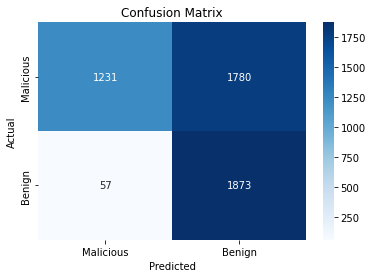

In [ ]:
model = buildSdA(1,1024)
model.fit(train_padded_norm,y_train,epochs=25, verbose=0)

bottleneck = Model (inputs=model.inputs, outputs=model.layers[0].output) #define only encoder structure

features_train= bottleneck.predict(train_padded_norm)
features_test= bottleneck.predict(test_padded_norm)

classifier = XGBClassifier(eta=0.1, colsample_bytree=0.8)
classifier.fit(features_train, y_train)
result = classifier.predict(features_test)

score = accuracy_score(y_test, result)

tn, fp, fn, tp = confusion_matrix(y_test, result).ravel()
tpr = (tp/(tp+fn))*100
fpr = (fp/(fp+tn))*100
fnr = (fn/(fn+tp))*100
tnr = (tn/(tn+fp))*100
matrix = confusion_matrix(y_test, result)
report = classification_report(y_test, result)
auc = roc_auc_score(y_test, result)
f1 = f1_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)
test_result = "\nAccuracy: %f\nAUC: %f\nF1: %f\nPrecision: %f\nRecall: %f\nTPR: %f\nFPR: %f\nFNR: %f\nTNR: %f\n" %(score,auc,f1, precision, recall, tpr,fpr,fnr,tnr)
print(report)
print(test_result)
cm = sns.heatmap(matrix, annot=True, fmt="d",cmap='Blues', xticklabels=['Malicious', 'Benign'],yticklabels=['Malicious', 'Benign'])
cm.set(xlabel='Predicted', ylabel='Actual',title="Confusion Matrix")
plt.show()

# References

[1] Choi, S., 2020. Malicious powershell detection using attention against adversarial attacks. Electronics, 9(11), p.1817.